# Behavioral Cloning with Keras

Use Keras to train a car in a simulator to clone my driving behavior.

Import all necessary libraries here.

In [1]:
import time
import cv2
import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import rgb_to_hsv
from scipy.stats import norm
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.core import Lambda, Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.advanced_activations import ELU

from scipy.signal import butter, lfilter, freqz
from scipy.misc import imsave
import os
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Dataset

To start with, I'm using the driving data provided by Udacity.

The data consists of images taken by cameras that point forward, slightly to the left and slightly to the right. The output are the steering angles. 

### Load the data

In [11]:
# Read in the data
def read_data_from_file(path):
    f = open(path)
    line = f.readline()
    # Data exploration: Find the min and max steering angle
    X_data_paths = []
    y_data = []
    while True:
        line = f.readline().strip()
        # If we reach the end of the file, return the data
        if line == '':
            return X_data_paths, y_data

        # Split the data from the line
        center, left, right, steering, throttle, brake, speed = line.split(', ')
        # Preprocess the data: Transform steering angle to float
        # The minimum and maximum of the steering angles are between -1 and 1.
        steering = float(steering)
        # Append the steering angle to the output data array
        y_data.append(steering)
        # Append the image path to the input data array
        X_data_paths.append(center)
        
        # Append the steering angle to the output data array
        y_data.append(steering + .25)
        # Append the image path to the input data array
        X_data_paths.append(left)
        
        # Append the steering angle to the output data array
        y_data.append(steering - .25)
        # Append the image path to the input data array
        X_data_paths.append(right)

# Load the data and shuffle it
X_data_paths, y_data = read_data_from_file('dataGathering/driving_log.csv')

print(len(X_data_paths))
print(len(y_data))

25131
25131


### Analyze the data and preprocess it

Let's look at the data by plotting a timeline and a histogram of the steering angles.

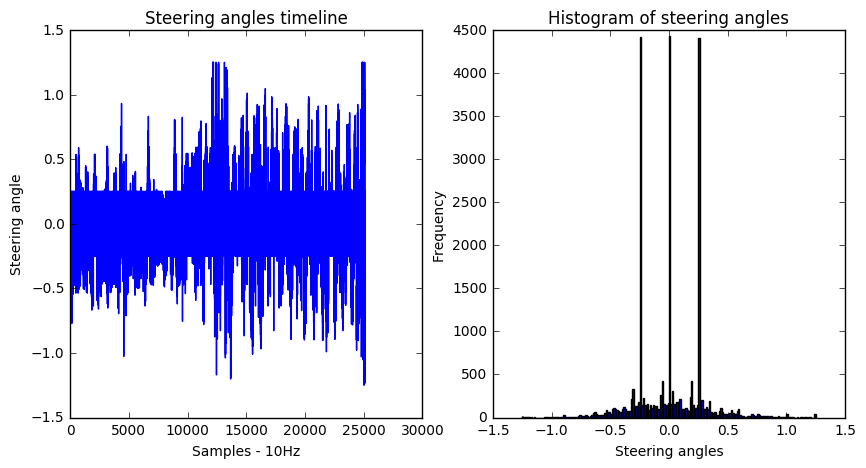

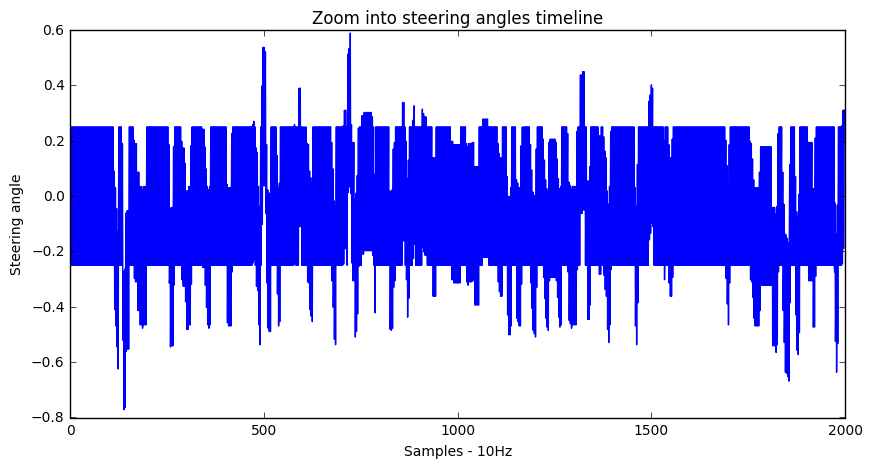

In [12]:
# Read image from a given path
def readImage(path):
    # image = mpimg.imread('data/' + path)
    image = mpimg.imread(path)
    return image

def resizeImage(image):
    # Crop the image: crop away the sky and the car hood
    # image = image[40:-20,:]
    image = image[60:-20,:]
    # Resize the image to fit the NVIDIA network
    # The required input is (66, 200, 3)
    image = cv2.resize(image, (200, 66))
    return image

def addChannelS(image):
    hsv = rgb_to_hsv(image)
    s = hsv[:,:,1] * 255
    image = np.dstack((image, s))
    return image

# Visualizations will be shown in the notebook.
%matplotlib inline

plt.figure(figsize=(10,5))
# Plot the steering angles over time
plt.subplot(121)
plt.plot(y_data)
plt.ylabel('Steering angle')
plt.xlabel('Samples - 10Hz')
plt.title('Steering angles timeline')

# Plot a histogram of steering angles
plt.subplot(122)
plt.hist(y_data, 200)
plt.ylabel('Frequency')
plt.xlabel('Steering angles')
plt.title('Histogram of steering angles')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(y_data[1:2000])
plt.ylabel('Steering angle')
plt.xlabel('Samples - 10Hz')
plt.title('Zoom into steering angles timeline')
plt.show()

The timeline of steering angles is very jittery. We will see if we can do something about that later.

Also, there is too much data for steering angles around 0, and not enough for steering angles < -0.5 and > 0.5. Next, lets plot a few examples to see images corresponding to the steering angles.

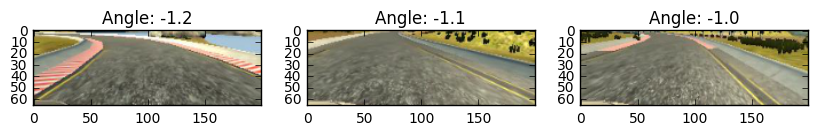

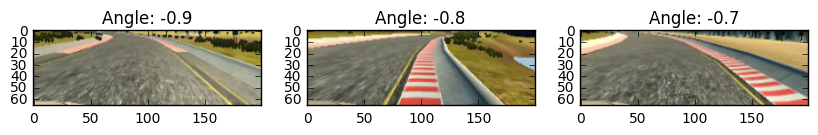

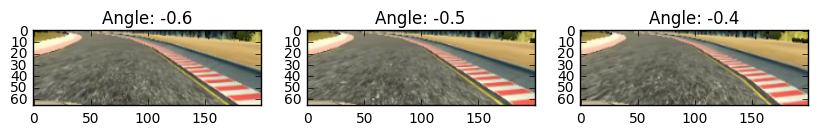

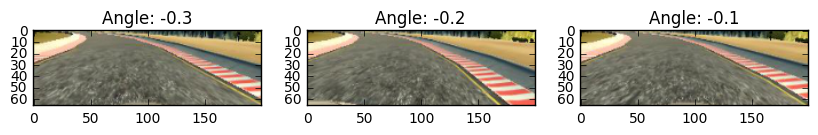

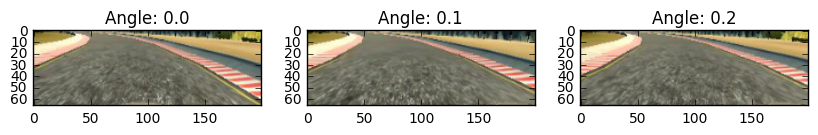

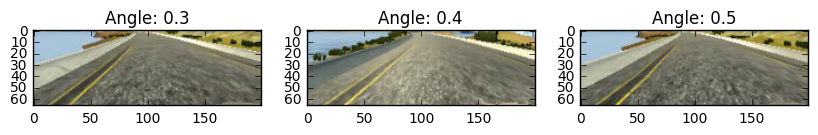

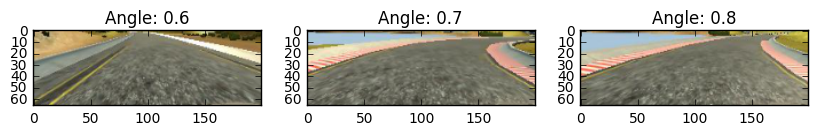

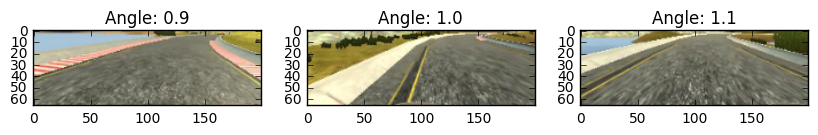

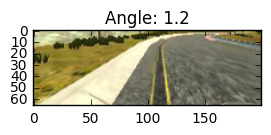

In [13]:
# Plot a few examples for a selection of steering angles
y_data_sampled = [int(x*10) for x in y_data]
min_angle = min(y_data_sampled)
max_angle = max(y_data_sampled)
counter = 0
for i in range(min_angle, max_angle+1):
    if i in y_data_sampled:
        index = y_data_sampled.index(i)
        image = readImage(X_data_paths[index])
        image = resizeImage(image)
        # image = addChannelS(image)
        if (counter%3 == 0):
            plt.figure(figsize=(10,10))
        plt.subplot(1,3,counter%3+1)
        plt.imshow(image)
        plt.title("Angle: " + str(float(i/10)))
        counter += 1

What happens if we average the steering angles? Let's use a running average filter and plot the steering angles.

Note: This is just to get a better understanding of the data - it is not necessary for teaching the network how to drive.

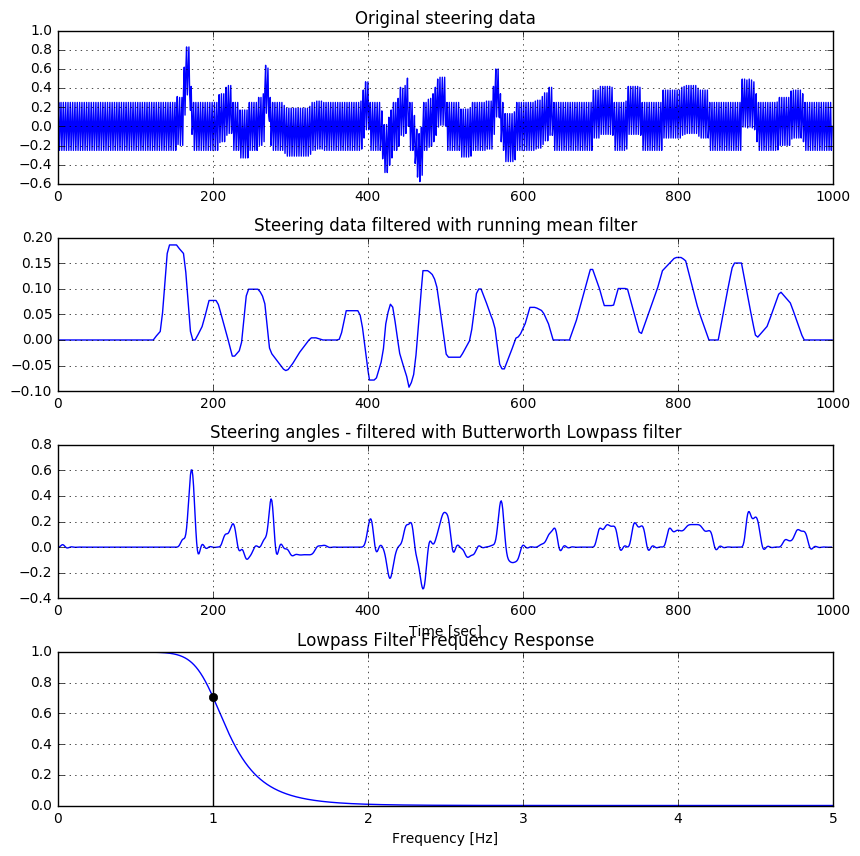

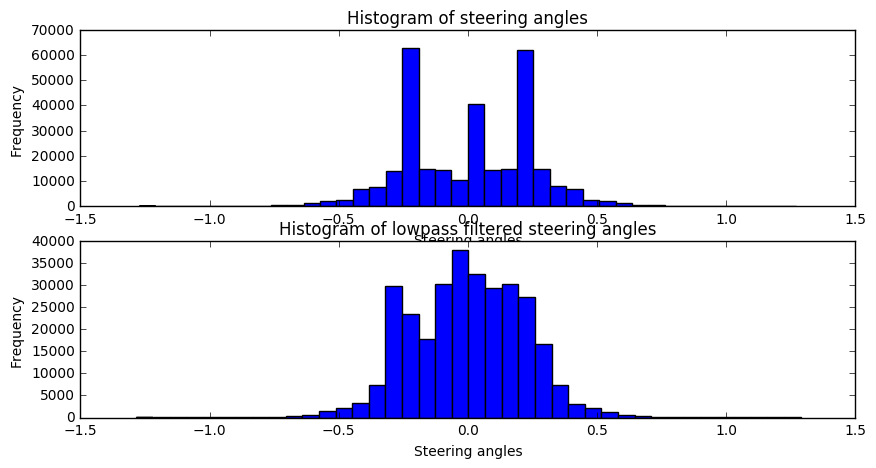

In [68]:
# Function to calculate the running mean of values in x, averaged over N entries
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

y_data_averaged = running_mean(y_data, 30)
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.35)
plt.subplot(411)
plt.title('Original steering data')
plt.plot(y_data[0:1000])
plt.grid()
plt.subplot(412)
plt.title('Steering data filtered with running mean filter')
plt.plot(y_data_averaged[0:1000])
plt.grid()

# Other attempt: use a butterworth lowpass filter
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Filter requirements
order = 6
fs = 10 # sample rate, Hz
cutoff = 1 # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response
# Filter the data, and plot both the original and filtered signals.
y_data_filtered = butter_lowpass_filter(y_data, cutoff, fs, order)

plt.subplot(413)
plt.plot(y_data_filtered[1:1000])
plt.xlabel('Time [sec]')
plt.title("Steering angles - filtered with Butterworth Lowpass filter")
plt.grid()

w, h = freqz(b, a, worN=8000)
plt.subplot(414)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(211)
plt.hist(y_data, 40)
plt.ylabel('Frequency')
plt.xlabel('Steering angles')
plt.title('Histogram of steering angles')

plt.subplot(212)
plt.hist(y_data_filtered, 40)
plt.ylabel('Frequency')
plt.xlabel('Steering angles')
plt.title('Histogram of lowpass filtered steering angles')
plt.show()

Not sure I'll use the filtered data - for now let's leave it as it is.

## Balance the data

The distribution of steering angles should preferably be uniform. That means, we need less steering angles around 0, the same number of steering angles for turning right and left, and more examples for steering right and left so it matches the number of 0 angles.

A few methods to achieve that would be:
1. Mirror left / right turns.
2. Perturb steering angles while keeping the same image.
3. Change light situation in images.

In [16]:
# Use viveks code to augment brightness
def augment_brightness(image):
    # Randomly select a percentage change
    random_bright = 0.25 + np.random.uniform()
    
    # Change to HSV to change the brightness V
    image_augmented = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image_augmented[:,:,2] = image_augmented[:,:,2]*random_bright
    
    # Convert back to RGB
    image_augmented = cv2.cvtColor(image_augmented,cv2.COLOR_HSV2RGB)
    return image_augmented

def mirror_image(image, angle):
    image_mirrored = cv2.flip(image,1)
    angle = -angle
    return image_mirrored, angle

def perturb_angle(angle):
    new_angle = angle * (1.0 + np.random.uniform(-1, 1)/30.0)
    return new_angle

hist_y_data = np.histogram(y_data, bins=20)
print(max(hist_y_data[0]))
print(np.mean(hist_y_data[0]))
print(hist_y_data)

# X_data_paths
# y_data
X_data_paths_augmented = X_data_paths
y_data_augmented = y_data
generated_image_counter = 1
for i in range(len(y_data)):
    if y_data[i] != 0:
        # Read image, save its path
        image = readImage(X_data_paths[i])
        path = X_data_paths[i][:-4]
        angle = y_data[i]
        # Mirror both image and angle
        image_mirrored, angle_mirrored = mirror_image(image, angle)
        path_mirrored = path + "_mirrored.jpg"
        # Save the new image and its angle
        # imsave("data/" + path_mirrored, image_mirrored)
        imsave(path_mirrored, image_mirrored)
        X_data_paths_augmented.append(path_mirrored)
        y_data.append(angle_mirrored)
print("done with part 1")

for i in range(len(y_data)):
    # Read image, save its path
    image = readImage(X_data_paths[i])
    path = X_data_paths[i][:-4]
    angle = y_data[i]
    # variations = 3
    if y_data[i] <= -0.5 or y_data[i] >= 0.5:
        variations = 2
    elif y_data[i] <= -0.2 or y_data[i] >= 0.2:
        variations = 1
    else:
        variations = 0
        
    # Augment brightness of images, keep same angle
    for j in range(variations):
        image_brightness = augment_brightness(image)
        path_brightness = path + "_brightness" + str(j) + ".jpg"
        # Save the new image and its angle
        # imsave("data/" + path_brightness, image_brightness)
        imsave(path_brightness, image_brightness)
        X_data_paths_augmented.append(path_brightness)
        y_data.append(angle)

    # Perturb angles but keep same image
    for j in range(variations):
        path_angle = path + "_angle" + str(j) + ".jpg"
        # Save the new image and its angle
        # imsave("data/" + path_angle, image)
        imsave(path_angle, image)
        X_data_paths_augmented.append(path_angle)
        new_angle = perturb_angle(angle)
        y_data.append(new_angle)
print("done with part 2")


5922
1256.55
(array([  18,    7,   73,   90,  261,  420,  876, 1457, 5737, 1747, 5922,
       1521, 5421,  540,  520,  174,  183,   70,   51,   43]), array([-1.25 , -1.125, -1.   , -0.875, -0.75 , -0.625, -0.5  , -0.375,
       -0.25 , -0.125,  0.   ,  0.125,  0.25 ,  0.375,  0.5  ,  0.625,
        0.75 ,  0.875,  1.   ,  1.125,  1.25 ]))
done with part 1
done with part 2


116193
116193


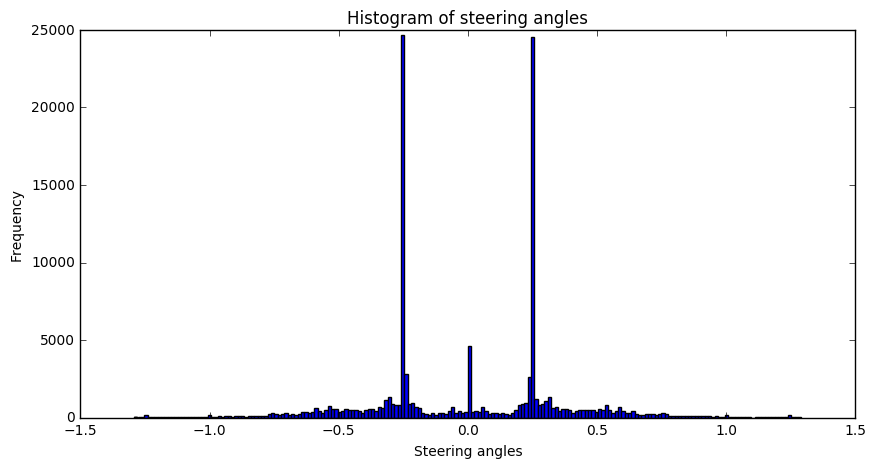

In [17]:
print(len(y_data))
print(len(X_data_paths))

plt.figure(figsize=(10,5))
plt.hist(y_data, 200)
plt.ylabel('Frequency')
plt.xlabel('Steering angles')
plt.title('Histogram of steering angles')
plt.show()

### Downsample the data

Now that I've increased the number of input / output data from roughly 25000 to 116000, I can take the new distribution and downsample images that are frequently represented. Let's split the data into 200 bins, and let's apply a uniform distribution.

Note: I've been playing around with normal distributions as well, which is why I have code included that allows the user to sample the data in a way that achieves various distributions. For submission we use a uniform distribution.

In [18]:
hist_y_data = np.histogram(y_data, bins=200)
# print(hist_y_data)

# Let's do this manually:
# print(hist_y_data[0][5:15])
# print(hist_y_data[1][5:15])
number_samples_bin = hist_y_data[0]
range_samples_bin = hist_y_data[1]

print(len(y_data))

116193


In [19]:
import pdb
# To introduce randomness, let's shuffle the data
hist_y_data = np.histogram(y_data, bins=200)
number_samples_bin = hist_y_data[0]
range_samples_bin = hist_y_data[1]
X, y = shuffle(X_data_paths, y_data)

# Trim the data into a normal (Gaussian) distribution
def normTrimData(X_data_paths, y_data, mean, std, numberBins, maxData):
    # Get the PDF
    pdf = norm(mean, std)
    
    # Get the bins from the histogram
    hist_y_data = np.histogram(y_data, bins=numberBins)
    number_samples_bin = hist_y_data[0]
    range_samples_bin = hist_y_data[1]
    #Shuffle the data to make it randomly distributed
    X, y = shuffle(X_data_paths, y_data)

    length_y = len(y)
    i = 0
    rangeY = max(y) - min(y)
    print(rangeY)
    stepsBins = rangeY / numberBins
    print(stepsBins)
    for counter in range(length_y):
        for j in range(len(number_samples_bin)-1):
            if y[i] >= range_samples_bin[j] and y[i] < range_samples_bin[j+1]:
                if number_samples_bin[j] >= pdf.pdf(y[i])*maxData:
                # if number_samples_bin[j] >= 200:
                    y.pop(i)
                    X.pop(i)
                    number_samples_bin[j] -= 1
                    i -= 1
                    break
        i += 1
        
    return X, y
        
# Trim the data into a uniform distribution       
def uniformTrimData(X_data_paths, y_data, numberBins, maxData):
    # Get the bins from the histogram
    hist_y_data = np.histogram(y_data, bins=numberBins)
    number_samples_bin = hist_y_data[0]
    range_samples_bin = hist_y_data[1]
    #Shuffle the data to make it randomly distributed
    X, y = shuffle(X_data_paths, y_data)

    length_y = len(y)
    i = 0
    for counter in range(length_y):
        for j in range(len(number_samples_bin)-1):
            if y[i] >= range_samples_bin[j] and y[i] < range_samples_bin[j+1]:
                if number_samples_bin[j] >= maxData:
                    y.pop(i)
                    X.pop(i)
                    number_samples_bin[j] -= 1
                    i -= 1
                    break
        i += 1

    return X, y

# Delete all examples with steering angles > 1 and < -1
def applyMinMax(X_data_paths, y_data):
    #Shuffle the data to make it randomly distributed
    X, y = shuffle(X_data_paths, y_data)

    length_y = len(y)
    i = 0
    for counter in range(length_y):
        if y[i] < -1. or y[i] > 1.:
            y.pop(i)
            X.pop(i)
            i -= 1
        i += 1

    return X, y
    
X, y = applyMinMax(X_data_paths, y_data)
# X, y = normTrimData(X, y, 0, 0.3, numberBins=200, maxData=200)
# X, y = uniformTrimData(X_data_paths, y_data, numberBins=200, maxData=200)
                    
print('done')
print(len(y_data))
print(len(X_data_paths))
print(len(y))
print(len(X))

done
116193
116193
115275
115275


In [29]:
X, y = uniformTrimData(X, y, 500, 200)
print('done')

done


32511
32511


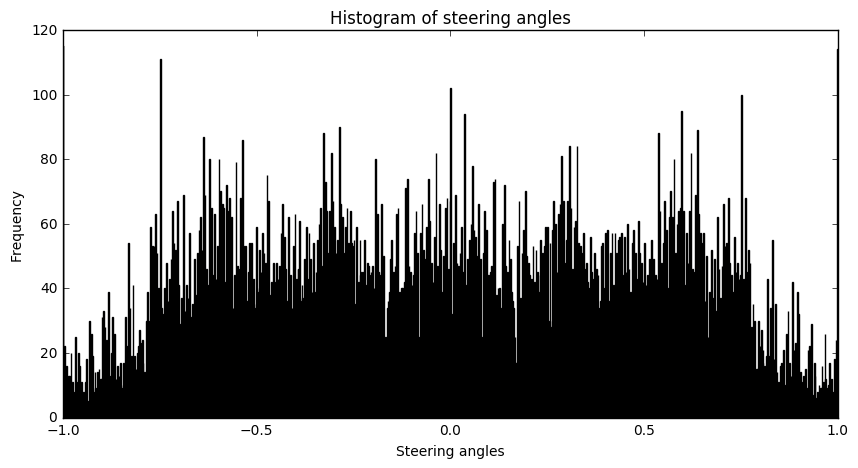

In [30]:
print(len(y))
print(len(X))

plt.figure(figsize=(10,5))
plt.hist(y, 1000)
plt.ylabel('Frequency')
plt.xlabel('Steering angles')
plt.title('Histogram of steering angles')
plt.show()

Above you can see the new distribution of the data. It is relatively uniform with a high representation of angles between -0.75 and 0.75. The tails are fat, so even data beyond the 0.75 values are well represented. 

### We need a python generator to load the images
The python generator loads images in batches rather than storing the entire training data in memory.


In [31]:
# Python generator to read in the images
def generator(X_data_paths, y_data):
    j = 0
    num_examples = len(y_data)
    while True:
        if j >= num_examples:
            j = 0
            X_data_paths, y_data = shuffle(X_data_paths, y_data)
        for offset in range(0, num_examples, batch_size):
            end = offset + batch_size
            batch_x_paths, batch_y = X_data_paths[offset:end], y_data[offset:end]

            batch_x = []
            for i in range(len(batch_x_paths)):
                image = readImage(batch_x_paths[i])
                image = resizeImage(image)
                # image = addChannelS(image)
                batch_x.append(image)

            j += 1
            batch_x = np.array(batch_x)
            batch_y = np.array(batch_y)
            yield(batch_x, batch_y)


### The NVIDIA architecture

We used the NVIDIA architecture as described in this paper:
http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf

We added some Dropout layers to reduce overfitting and RELU and ELU activation layers to introduce nonlinearity. 

In [32]:
# Network Architecture
def nvidia_model():
    model = Sequential()

    # 1st Layer - Normalize the image to values between [0.5, 0.5]
    model.add(Lambda(lambda x: -1 + x/127.5, input_shape=(66, 200, 3)))

    # 3 layers of Convolution with 5x5 kernel and 2x2 stride
    # init='he_normal': Initialization of random weights with Gaussian
    # initialization
    model.add(Convolution2D(24, 5, 5, activation='relu', subsample=(2,2),
                            border_mode="valid", init='he_normal'))
    model.add(Convolution2D(36, 5, 5, activation='relu', subsample=(2,2),
                            border_mode="valid", init='he_normal'))
    model.add(Convolution2D(48, 5, 5, activation='relu', subsample=(2,2),
                            border_mode="valid", init='he_normal'))

    # 2 layers of Convolution with 3x3 kernel and no stride
    model.add(Convolution2D(64, 3, 3, activation='relu', subsample=(1,1),
                            border_mode="valid", init='he_normal'))
    model.add(Convolution2D(64, 3, 3, activation='relu', subsample=(1,1),
                            border_mode="valid", init='he_normal'))

    model.add(Flatten())
    model.add(Dense(100, init='he_normal'))
    model.add(ELU())
    model.add(Dropout(0.3))
    model.add(Dense(50, init='he_normal'))
    model.add(ELU())
    model.add(Dense(10, init='he_normal'))
    model.add(ELU())
    model.add(Dropout(0.3))
    model.add(Dense(1, init='he_normal'))
    return model


### Compile and run the model
First, choose the hyperparameters. Then, compile and train the model.

Note: I chose a val_samples size that is much smaller than the recommended 20%. My bad.

In [33]:
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [34]:
batch_size = 125
samples_per_epoch = 32511
nb_epoch = 12
val_samples = 1000

In [35]:
model = nvidia_model()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
history = model.fit_generator(generator(X_train, y_train), 
                              validation_data=generator(X_validation, y_validation),
                              nb_val_samples=val_samples,
                              samples_per_epoch=samples_per_epoch, 
                              nb_epoch=nb_epoch)


Epoch 1/12
32508/32511 [============================>.] - ETA: 0s - loss: 0.3326 - mean_absolute_error: 0.3584   

/Users/kasiunia/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1537: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


32633/32511 [==============================] - 232s - loss: 0.3318 - mean_absolute_error: 0.3580 - val_loss: 0.0964 - val_mean_absolute_error: 0.2457
Epoch 2/12
32633/32511 [==============================] - 225s - loss: 0.0931 - mean_absolute_error: 0.2415 - val_loss: 0.0655 - val_mean_absolute_error: 0.2022

In [36]:
model.save('hil_ram_500_200.h5')
print(model)

## Summary
The absolute mean validation error was surprisingly high in this run - usually a absolute mean error of 0.1 was the lowest I could reach, and it is somewhat an indicator for the performance of the car. This model was made from recorded data from 3 drivers, and they were driving wildly differently (safe vs aggressive). 

The model resultet in a slightly less stable model than I have managed to get before, but you can see the driving behavior reflected from our driving styles.